### Titanic survival prediction
This piece of code has the purpose of comparing different machine learning algoriths for the Titanic survival dataset (available on Kaggle https://www.kaggle.com/c/titanic)  

#### Objective:  
We will perform several models (tree, random forest, logistic regression in particular, chosen based on dataset's nature) and analyse their performance in terms of **accuracy rate** and **running time** (fit and score time)

In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score




In [2]:
cwd = os.getcwd()
train_raw = pd.read_csv(cwd + r'\train.csv')


# keep train data untouched in _raw datasets, and manipulate it in train
train = train_raw.copy()



### 1. Overview of dataset

In [3]:
# train dataset
print(train.info())
print('='*20)
print(train.isnull().sum())
print('='*20)
print(train.describe(include = 'all'))
print('='*20)
print(train.head(5))  
print('='*20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int6

>#### First thoughts
>- Variables/Features:  
>    - A priori, Id, Ticket, Cabin, Name are not related to survival rate, to be discarded  
>    - Among the remaining variables, to test survival rate's relationship with the following variables **Pclass, Sex, SibSp, Parch, Embarked, Age, Fare** 
>- Model:  
>    - As potential valuable variables include both discrete and continuous variables, we consider in the first place **tree based models** (e.g. decision tree, random forest, gradient boosting) and we will also test logistic regression classifier



In [4]:
f_total = train.columns.values
f_excluded = ['PassengerId', 'Ticket', 'Cabin', 'Name']

### 2. Explotary analysis 
Objectives:
- to see correlation between features (discrete and continuous) and survival rate  
- to understand features' structure

In [5]:
f_list = []
for f in list(set(f_total) - set(f_excluded)-{'Survived'}) :
    f_list.append([f,train[f].unique().size])
f_df = pd.DataFrame(f_list, columns = ['features', '# of unique values']).set_index('features')
f_discrete = list(f_df.loc[f_df['# of unique values']<10].index.values)
f_continuous = list(set(f_df.index.values) - set(f_discrete))
print('discrete features:',f_discrete,'\ncontinuous features', f_continuous)

discrete features: ['Parch', 'SibSp', 'Embarked', 'Sex', 'Pclass'] 
continuous features ['Fare', 'Age']


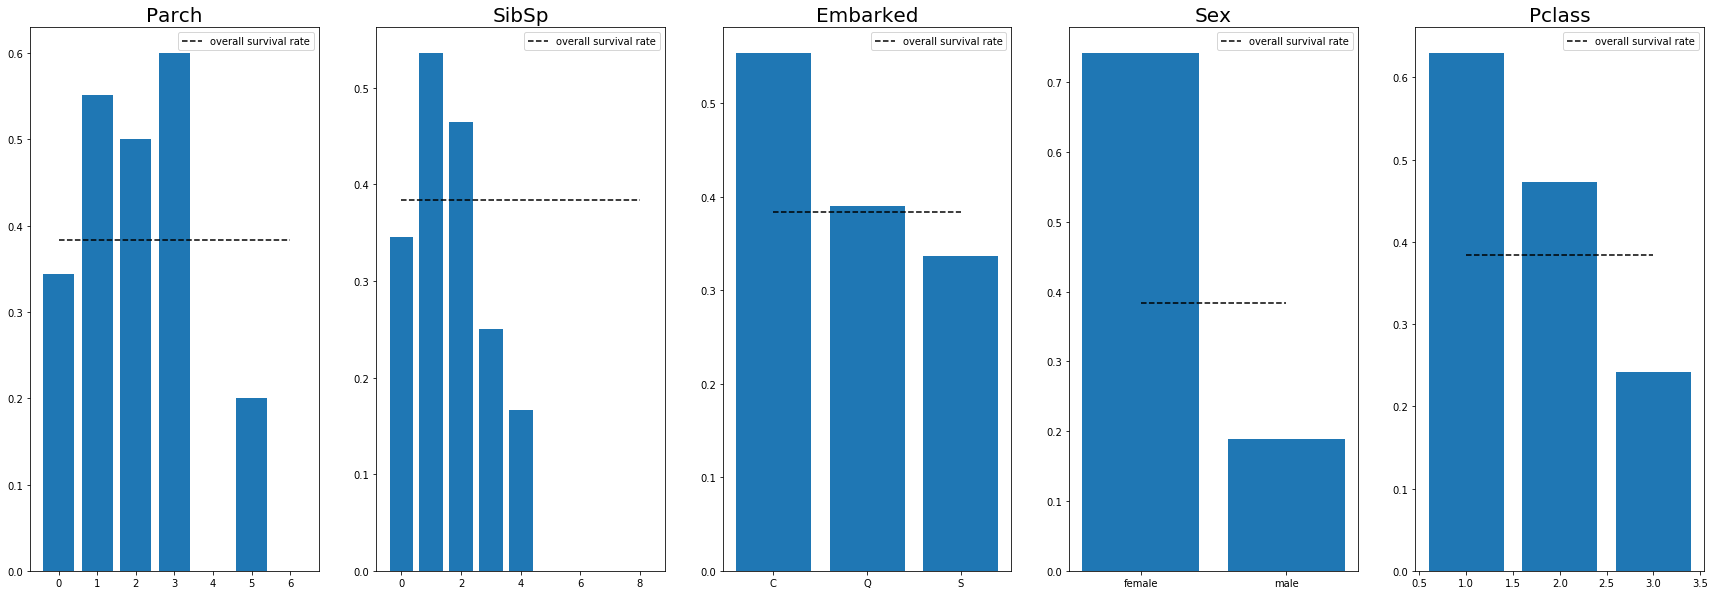

In [6]:
survival_rate = train.Survived.mean()

# Discrete variables
fig, axs = plt.subplots(1,len(f_discrete),figsize = (30,10))
for i,f in enumerate(f_discrete):
    df = train[[f,'Survived']].groupby(f).mean()
    axs[i].bar(df.index.values,df.Survived) 
    axs[i].plot(df.index.values,[survival_rate]*len(df.index.values),'k--',label = 'overall survival rate')
    axs[i].set_title(str(f), fontsize= 20)
    axs[i].legend()

>#### Comments
>- Sex and Pclass are important features: Female and higher class have higher survival rate
>- Higher survival rate with small but non zero SibSp, Parch numbers
>- Embarked at C has higher survival rate

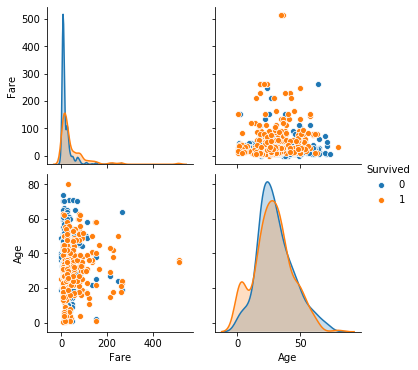

In [7]:
# continuous variables
f = f_continuous.copy()
f.append('Survived')
df = train[f].copy()
sns.pairplot(df, hue = 'Survived') 


> #### Comments
>- Age may be correlated to survival rate, with small age child having higher survival rate  
>- Fare may be correlated to survival rate, higher fare rate individuals having higher survival rate

In [8]:
features = f_discrete + f_continuous

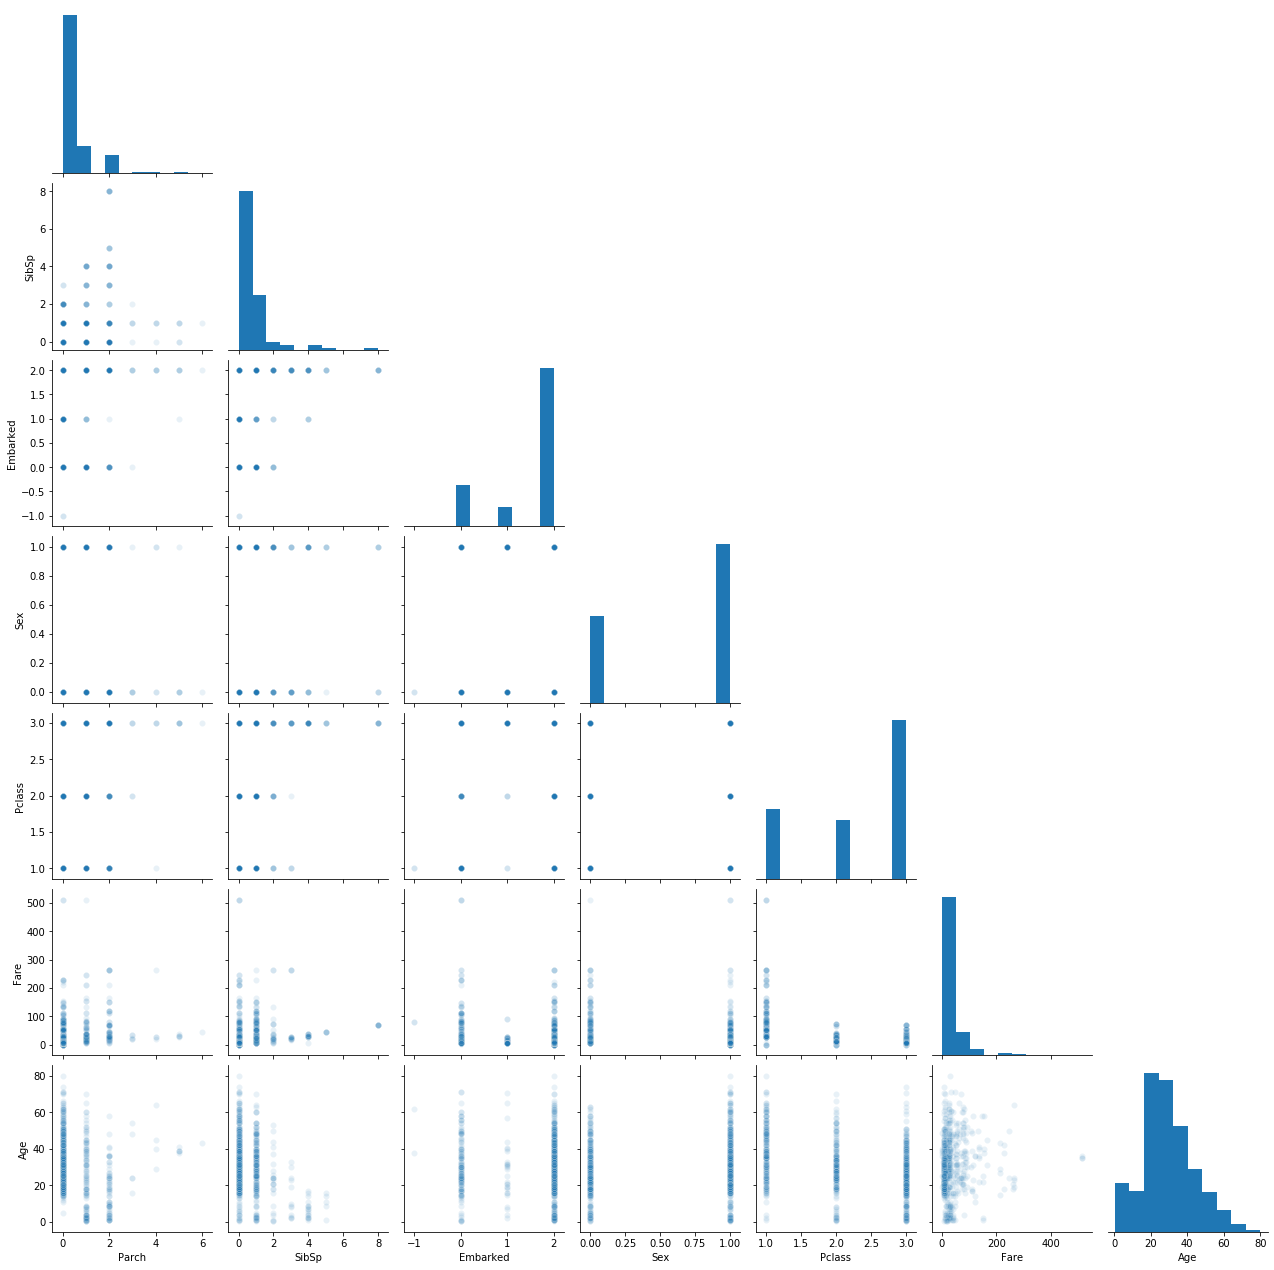

In [9]:
# Explore pariwise relationship of variables

df = train[features].copy()
f_object = train[features].select_dtypes(include = 'object').columns.values

for f in f_object:
    df[f] = df[f].astype('category')
    df[f] = df[f].cat.codes
    
sns.pairplot(df,corner = True,plot_kws={ 'alpha': 0.1})

>#### Comments
>- Age and Fare have long right tail
>- Fare and Pclass are correlated, i.e. Pclass can be used to fill out Fare's missing values

### 3. feature enginering 
3.1. Fill up missing values  
3.2. Create new features  
3.3. Encode categorical variables

#### 3.1 Fill up missing values 
To fill up features: 
- Ages 
- Embarked 

In [10]:
age_guess = train['Age'].median()
embarked_guess = train['Embarked'].mode()

train['Age'].fillna(age_guess, inplace = True)
train['Embarked'].fillna(embarked_guess, inplace = True)


#### 3.2 Create new features
- To extract title from name  

In [13]:
train['Title'] = train['Name'].str.extract(pat = '.*\ (.*)\..*')

print(train['Title'].value_counts())

titles_regular = ['Mr','Miss','Mrs','Master']

train['Title'] = train['Title'].apply(lambda x: x if x in titles_regular else 'Rare')

features.append('Title')

Mr          517
Miss        182
Mrs         124
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Ms            1
Capt          1
Lady          1
L             1
Mme           1
Jonkheer      1
Countess      1
Don           1
Sir           1
Name: Title, dtype: int64


> #### Comments
> other methods to extract title from name:
>- train['Title'] = train['Name'].str.extract(pat = '([A-Za-z]+)\.')
>- train['Title'] = train['Name'].str.extract(pat = '.*\ (.*)\..*')
>- train['Title'] = train['Name']  
    train['Title'] = train['Title'].apply(lambda name: name[name.find(',')+2:name.find('.')])


#### 3.3 Ajust variables type
- To encode 
     - the categorical variables Sex and Embarked
     - variable Title considered to be ordered (since there is rare and the list is in descending frequency order)
- Ordered variables (Pclass, Parch, SibSp) already in int format and continuous variables Age and Fare already in float format

In [14]:
train[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Parch     891 non-null    int64  
 1   SibSp     891 non-null    int64  
 2   Embarked  889 non-null    object 
 3   Sex       891 non-null    object 
 4   Pclass    891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Age       891 non-null    float64
 7   Title     891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


In [15]:
train['Title'] = train['Title'].astype('category')
train['Title'] = train['Title'].cat.codes 
train = pd.get_dummies(train, columns = ['Sex', 'Embarked']) 


In [16]:
features = list(set(train.columns.values.tolist()) - set(f_excluded))
features.remove('Survived')
print(features)

['Parch', 'Embarked_Q', 'SibSp', 'Fare', 'Sex_female', 'Embarked_S', 'Title', 'Age', 'Sex_male', 'Embarked_C', 'Pclass']


In [17]:
# Sanity check
train[features].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Parch       891 non-null    int64  
 1   Embarked_Q  891 non-null    uint8  
 2   SibSp       891 non-null    int64  
 3   Fare        891 non-null    float64
 4   Sex_female  891 non-null    uint8  
 5   Embarked_S  891 non-null    uint8  
 6   Title       891 non-null    int8   
 7   Age         891 non-null    float64
 8   Sex_male    891 non-null    uint8  
 9   Embarked_C  891 non-null    uint8  
 10  Pclass      891 non-null    int64  
dtypes: float64(2), int64(3), int8(1), uint8(5)
memory usage: 40.2 KB


### 4. modeling 
Compare 3 models:
- Tree, can be served as a baseline model
- Random forest classifier
- Logistic regression


In [50]:
X = train[features]
y = train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


analysis = pd.DataFrame([], columns = ['accuracy rate', 'time consumption'], index = ['Tree', 'Random forest', 'Logistic regression'])

#### 4.1 Tree classifier

In [45]:
tree = DecisionTreeClassifier(random_state = 0)

params = {'max_depth': [2,3,5]}

model_cv = GridSearchCV(tree, cv = 5, param_grid = params, return_train_score = True)
model_cv.fit(X_train,y_train)

cv_results = model_cv.cv_results_
results = pd.DataFrame(index = cv_results['params'])
results['test'] = list(cv_results['mean_test_score'])
results['train'] = list(cv_results['mean_train_score'])
results['diff'] =  results['train'] - results['test']
print(results.sort_values(by = 'diff', ascending = True))
print(model_cv.best_params_)

                      test     train      diff
{'max_depth': 3}  0.820258  0.835873  0.015615
{'max_depth': 2}  0.762413  0.795345  0.032932
{'max_depth': 5}  0.807432  0.868376  0.060944
{'max_depth': 3}


#### Comments
>- The best parameter for max_depth is 3

In [51]:
tree = model_cv.best_estimator_
cv_score = cross_validate(tree, X_train, y_train, cv = 5)
tree_time = np.column_stack((cv_score['fit_time'],cv_score['score_time']))
print('tree model:\nfit and score time is:',sum(tree_time.mean(axis = 0)))

tree.fit(X_train, y_train)
print('accuracy rate is:',tree.score(X_test, y_test))

analysis.loc['Tree','accuracy rate'] = tree.score(X_test, y_test)
analysis.loc['Tree','time consumption'] = sum(tree_time.mean(axis = 0))


tree model:
fit and score time is: 0.006263303756713867
accuracy rate is: 0.8246268656716418


#### 4.2 Random forest classifier

In [21]:
rf = RandomForestClassifier(random_state = 0)

params = {'max_depth': [2,3,5], 
          'n_estimators': [100, 200]}

rf_cv = GridSearchCV(rf, cv = 5, param_grid = params, return_train_score = True)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_)
cv_results = rf_cv.cv_results_
results = pd.DataFrame(index = cv_results['params'])
results['test'] = list(cv_results['mean_test_score'])
results['train'] = list(cv_results['mean_train_score'])
results['diff'] =  results['train'] - results['test']
print(results.sort_values(by = 'diff', ascending = True))

{'max_depth': 5, 'n_estimators': 100}
                                           test     train      diff
{'max_depth': 2, 'n_estimators': 100}  0.793019  0.798155  0.005136
{'max_depth': 2, 'n_estimators': 200}  0.788206  0.796151  0.007944
{'max_depth': 3, 'n_estimators': 200}  0.807458  0.821832  0.014374
{'max_depth': 3, 'n_estimators': 100}  0.807458  0.822234  0.014776
{'max_depth': 5, 'n_estimators': 200}  0.828297  0.857541  0.029244
{'max_depth': 5, 'n_estimators': 100}  0.828297  0.858342  0.030045


In [42]:
rf = rf_cv.best_estimator_
cv_results = cross_validate(rf, X_train, y_train, cv = 5, return_estimator = True)

In [43]:
rf_time = np.column_stack((cv_results['fit_time'],cv_results['score_time']))
print('random forest fit and score time is:',sum(rf_time.mean(axis = 0)))

random forest fit and score time is: 0.3297085285186767


In [23]:
importances = []

for i,e in enumerate(cv_results['estimator']):
    importances.append(e.feature_importances_)
importances_df = pd.DataFrame(importances,columns = features)
importances_mean = importances_df.mean(axis = 0)
importances_mean.sort_values(ascending = False)

Sex_female    0.218017
Sex_male      0.216182
Pclass        0.120352
Title         0.118431
Fare          0.109535
Age           0.085559
SibSp         0.059816
Parch         0.029938
Embarked_S    0.017296
Embarked_C    0.013619
Embarked_Q    0.011255
dtype: float64

#### Comments
- Random forest increasing the possibility of overfitting by randomly picking noise features, We need select the features with the highest importance.   
- To select most important features, we examin the features_importances_ by combining the same variable importances and looking at the ranking of discrete and continuous variables seperating:  
>- Discrete variables:
>    - `Sex is the most important variable` with total importance at 0.59
>    - Followed by `Title` (0.12) and `Pclass` (0.10)
>- Continuous variables: Keep `Fare` variable

In [52]:
# feature selection
features_rf = ['Sex_female', 'Sex_male', 'Title','Pclass','Fare']
X_train_rf = X_train[features_rf]
X_test_rf = X_test[features_rf]
rf.fit(X_train_rf, y_train)
print('accuracy rate is:',rf.score(X_test_rf, y_test))

analysis.loc['Random forest','accuracy rate'] = rf.score(X_test_rf, y_test)
analysis.loc['Random forest','time consumption'] = sum(rf_time.mean(axis = 0)) 

accuracy rate is: 0.8283582089552238


In [25]:
# Comparison of Tree and Random Forest Model
y_pred_tree = tree.predict(X_test)
y_pred_rf = rf.predict(X_test_rf)
y_compare = pd.DataFrame(np.column_stack((y_test, y_pred_tree, y_pred_rf)),columns = ['y_test','Tree','RF'],index = X_test.index)
compare = pd.concat([X_test,y_compare], axis = 1)
compare.loc[compare['Tree'] != compare['RF']]

,Parch,Embarked_Q,SibSp,Fare,Sex_female,Embarked_S,Title,Age,Sex_male,Embarked_C,Pclass,y_test,Tree,RF
530,1,0,1,26.0,1,1,1,2.0,0,0,2,1,0,1


#### Comments
The Tree model seems having similar predictions (and thus performance) as the random forest model

#### 4.3 Logistic regression

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression()
params = {'C': [0.1, 0.3, 1, 3, 10]}

logreg_cv = GridSearchCV(logreg, params, cv = 5, return_train_score = True)
logreg_cv.fit(X_train_scaled, y_train)

cv_results = logreg_cv.cv_results_
results = pd.DataFrame(index = cv_results['params'])
results['test'] = list(cv_results['mean_test_score'])
results['train'] = list(cv_results['mean_train_score'])
results['diff'] =  results['train'] - results['test']
print(results.sort_values(by = 'diff', ascending = True))
print('best pramater chosen by algorithm is:', logreg_cv.best_params_)

                test     train      diff
{'C': 0.1}  0.796219  0.806584  0.010365
{'C': 3}    0.788219  0.801367  0.013147
{'C': 10}   0.786619  0.800564  0.013945
{'C': 0.3}  0.791419  0.805381  0.013962
{'C': 1}    0.786606  0.803372  0.016766
best pramater chosen by algorithm is: {'C': 0.1}


In [30]:
logreg = logreg_cv.best_estimator_
coef = pd.Series((*logreg.coef_), index = features)
print(coef.sort_values())

Pclass       -0.741007
Sex_male     -0.603564
Age          -0.372114
SibSp        -0.360540
Embarked_S   -0.122506
Title        -0.090034
Parch        -0.076476
Embarked_Q    0.017113
Embarked_C    0.066723
Fare          0.092082
Sex_female    0.603564
dtype: float64


0.7947761194029851

#### Comments
From the coefficients we understand that:  
>`Being a female, in a higher class, young and having less siblings increases the chance of survival`, which confirms our intuition/general information on the Titanic story

In [53]:
cv_score = cross_validate(logreg, X_train_scaled, y_train, cv = 5)
logreg_time = np.column_stack((cv_score['fit_time'],cv_score['score_time']))
print('logistic regression:\nfit and score time is:',sum(logreg_time.mean(axis = 0)))
logreg.fit(X_train_scaled, y_train)
print('accuracy rate is:',logreg.score(X_test_scaled,y_test))

analysis.loc['Logistic regression','accuracy rate'] = logreg.score(X_test_scaled,y_test)
analysis.loc['Logistic regression','time consumption'] = sum(logreg_time.mean(axis = 0)) 

logistic regression:
fit and score time is: 0.01128072738647461
accuracy rate is: 0.7947761194029851


In [55]:
analysis

,accuracy rate,time consumption
Tree,0.824627,0.0062633
Random forest,0.828358,0.329709
Logistic regression,0.794776,0.0112807


#### Conclusion

- In terms of **accuracy score**: 
    - The 3 models have similar performance, with `tree based models having slightly better performance` around 0.82
- In terms of **time consumption**:  
    - `Tree model excels` due to its simplicity and random forest consumes the logest time

Overall, **tree model suits the best** this Titanic dataset among the 3 models investigated
